In [1]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_grad_enabled(False)

/home/jovyan/.mlspace/envs/svtdanny/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install flash-attn

In [3]:
dtype = torch.bfloat16

In [4]:
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B"
                                             , attn_implementation="sdpa"
                                             ,torch_dtype=dtype)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

In [5]:
model.to("cuda")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [6]:
text = "Hello, how are you?"
inputs = tokenizer(text, return_tensors="pt")
outputs = model.generate(input_ids = inputs["input_ids"].to("cuda"), attention_mask = inputs["attention_mask"].to("cuda"), max_new_tokens=20)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [7]:
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hello, how are you? I hope you are doing fine. Today I am sharing a tutorial for you, how to make a


In [8]:
def group_gemm_naive(As, Bs):
    return [A @ B for A, B in zip(As, Bs)]

import cutlass
def group_gemm_jit(As, Bs):
    dtype = As[0].dtype
    plan = cutlass.op.GroupedGemm(element=dtype, element_accumulator=torch.float32, layout=cutlass.LayoutType.RowMajor)

    Cs = [torch.zeros(a.shape[:-1] + (b.shape[-1],), dtype=a.dtype, device=a.device) for a,b in zip(As, Bs)]
    Ds = [torch.zeros_like(el) for el in Cs]
    
    plan.run(As, Bs, Cs, Ds, print_module=True)
    op = plan.construct()
    grouped_gemm = cutlass.emit.pytorch(op, name='grouped_gemm', cc=plan.cc, sourcedir='out', jit=True)

    return grouped_gemm

def get_group_gemm():
    gemm_fn = None
    
    def group_gemm(As, Bs):
        nonlocal gemm_fn
        if gemm_fn is None:
            print(f"jit compile As: {[a.shape for a in As]} Bs: {[b.shape for b in Bs]}")
            gemm_fn = group_gemm_jit(As, Bs)

        return gemm_fn.run(As, Bs)

    return group_gemm


In [9]:
grouped_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B", 
    attn_implementation="sdpa",
    # attn_implementation="eager",
    torch_dtype=dtype
)
grouped_model.to("cuda")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [10]:
q_proj_group = [l.self_attn.q_proj.weight.data.T.contiguous() for l in model.model.layers]
k_proj_group = [l.self_attn.k_proj.weight.data.T.contiguous() for l in model.model.layers]
v_proj_group = [l.self_attn.v_proj.weight.data.T.contiguous() for l in model.model.layers]
o_proj_group = [l.self_attn.o_proj.weight.data.T.contiguous() for l in model.model.layers]

gate_proj_group = [l.mlp.gate_proj.weight.data.T.contiguous() for l in model.model.layers]
up_proj_group = [l.mlp.up_proj.weight.data.T.contiguous() for l in model.model.layers]
down_proj_group = [l.mlp.down_proj.weight.data.T.contiguous() for l in model.model.layers]


inp_layer_norm_group = [l.input_layernorm.weight.data for l in model.model.layers]
post_attention_layernorm_group = [l.post_attention_layernorm.weight.data for l in model.model.layers]

inp_layer_norm_group = torch.stack(inp_layer_norm_group)
post_attention_layernorm_group = torch.stack(post_attention_layernorm_group)

In [11]:
def get_grouped_forward(Ws):
    def forward(Xs):
        res_list = group_gemm_naive(Xs.unbind(0), Ws)
        res = torch.stack(res_list)
        # print(f"Outs: {res.shape}")
        return res
    return forward
    
def get_grouped_gemm_forward(Ws):
    gemm_fn = get_group_gemm()
    
    def forward(Xs):
        nonlocal gemm_fn
        # print(f"Xs: {Xs.shape}")
        res_list = gemm_fn(Xs.unbind(0), Ws)
        # res_list = group_gemm_naive(Xs.unbind(0), Ws)
        res = torch.stack(res_list)
        # print(f"Outs: {res.shape}")
        return res
    return forward

In [12]:
grouped_attn = grouped_model.model.layers[0].self_attn

In [13]:
grouped_attn.q_proj.forward = get_grouped_gemm_forward(q_proj_group)
grouped_attn.k_proj.forward = get_grouped_gemm_forward(k_proj_group)
grouped_attn.v_proj.forward = get_grouped_gemm_forward(v_proj_group)
grouped_attn.o_proj.forward = get_grouped_gemm_forward(o_proj_group)

In [14]:
layer_inp = torch.rand((len(model.model.layers), 256, 2048), dtype=dtype, device="cuda")

In [15]:
layer_inp.shape, layer_inp[:, :, 0].shape

(torch.Size([16, 256, 2048]), torch.Size([16, 256]))

In [16]:
o0l, _, _ = grouped_attn.forward(
layer_inp, None, layer_inp[:, :, 0]
)

jit compile As: [torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048])] Bs: [torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048]), torch.Size([2048, 2048])]

// Gemm operator cutlass_tensorop_bf16_s16816gemm_grouped_bf16_256x128_64x3_tt_align8
using cutlass_tensorop_bf16_s16816gemm_grouped_bf16_256x128_64x3_tt_align8_

The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.


jit compile As: [torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048]), torch.Size([256, 2048])] Bs: [torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512]), torch.Size([2048, 512])]

// Gemm operator cutlass_tensorop_bf16_s16816gemm_grouped_bf16_256x128_64x3_tt_align8
using cutlass_tensorop_bf16_s16816gemm_grouped_bf16_256x128_64x3_tt_align8_base =
  typenam

In [ ]:
o0l[0]

tensor([[ 0.0747, -0.0085,  0.0226,  ..., -0.0366,  0.0165, -0.0137],
        [ 0.0471, -0.0142,  0.0334,  ..., -0.0598,  0.0046, -0.0532],
        [ 0.0583, -0.0227,  0.0277,  ..., -0.0359,  0.0104, -0.0366],
        ...,
        [ 0.0554, -0.0166,  0.0339,  ..., -0.0204,  0.0117, -0.0352],
        [ 0.0432, -0.0090,  0.0332,  ..., -0.0146,  0.0098, -0.0317],
        [ 0.0500, -0.0078,  0.0488,  ..., -0.0178,  0.0143, -0.0280]],
       device='cuda:0', dtype=torch.bfloat16)

In [18]:
o1l, _, _ = model.model.layers[0].self_attn(
layer_inp, None, layer_inp[:, :, 0]
)

In [19]:
o1l[0]

tensor([[ 0.0747, -0.0085,  0.0226,  ..., -0.0366,  0.0165, -0.0137],
        [ 0.0471, -0.0142,  0.0334,  ..., -0.0598,  0.0046, -0.0532],
        [ 0.0583, -0.0227,  0.0277,  ..., -0.0359,  0.0104, -0.0366],
        ...,
        [ 0.0554, -0.0166,  0.0339,  ..., -0.0204,  0.0117, -0.0352],
        [ 0.0432, -0.0090,  0.0332,  ..., -0.0146,  0.0098, -0.0317],
        [ 0.0500, -0.0078,  0.0488,  ..., -0.0178,  0.0143, -0.0280]],
       device='cuda:0', dtype=torch.bfloat16)

In [20]:
torch.allclose(o1l[0], o0l[0]) # use same attention impl

True

In [21]:
grouped_layer = grouped_model.model.layers[0]

In [22]:
grouped_layer

LlamaDecoderLayer(
  (self_attn): LlamaSdpaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=512, bias=False)
    (v_proj): Linear(in_features=2048, out_features=512, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
)

In [23]:
grouped_layer.self_attn.q_proj.forward = get_grouped_forward(q_proj_group)
grouped_layer.self_attn.k_proj.forward = get_grouped_forward(k_proj_group)
grouped_layer.self_attn.v_proj.forward = get_grouped_forward(v_proj_group)
grouped_layer.self_attn.o_proj.forward = get_grouped_forward(o_proj_group)

grouped_layer.mlp.gate_proj.forward = get_grouped_forward(gate_proj_group)
grouped_layer.mlp.up_proj.forward = get_grouped_forward(up_proj_group)
grouped_layer.mlp.down_proj.forward = get_grouped_forward(down_proj_group)

grouped_layer.input_layernorm.weight.data = inp_layer_norm_group[:, None, :]
grouped_layer.post_attention_layernorm.weight.data = post_attention_layernorm_group[:, None, :]

# inp_layer_norm_group = torch.stack(inp_layer_norm_group)
# post_attention_layernorm_group = torch.stack(post_attention_layernorm_group)

In [24]:
inp_layer_norm_group.shape

torch.Size([16, 2048])

In [25]:
o0 = grouped_layer.forward(
    layer_inp, None, layer_inp[:, :, 0]
)

In [26]:
o1 = model.model.layers[0].forward(
    layer_inp, None, layer_inp[:, :, 0]
)

In [27]:
# use same attention implementation. Even with that, can be little problems
torch.allclose(o0[0][0], o1[0][0], atol=1e-2) 

True

In [28]:
class SequentialBatcher:
    def __init__(self, seg_size):
        self.segment_storage = []
        self.seg_size = seg_size
        self.cur_cont = 0

        self.out_storage = {}
    
    def push(self, context, position_ids, positional_embeddings):
        self.segment_storage.append(
            [
            self.cur_cont,
            context.split(self.seg_size, dim=1),
            position_ids.split(self.seg_size, dim=1),
            list(zip(positional_embeddings[0].split(self.seg_size, dim=1),
            positional_embeddings[1].split(self.seg_size, dim=1)))
            ]
        )
        segm_id = self.cur_cont
        self.cur_cont += 1

        return segm_id

    def next(self):
        if not self.segment_storage:
            return None

        next_segm_info = (self.segment_storage[0][0], self.segment_storage[0][1][0], self.segment_storage[0][2][0], self.segment_storage[0][3][0])

        self.segment_storage[0][1] = self.segment_storage[0][1][1:]
        self.segment_storage[0][2] = self.segment_storage[0][2][1:]
        self.segment_storage[0][3] = self.segment_storage[0][3][1:]
        
        if len(self.segment_storage[0][1]) == 0:
            self.segment_storage = self.segment_storage[1:]

        return next_segm_info
    
    def push_out(self, segm_id, segm_out):
        if segm_id not in self.out_storage:
            self.out_storage[segm_id] = []

        self.out_storage[segm_id].append(segm_out)

    def get_context_output(self, segm_id):
        segm_out = torch.concat(self.out_storage[segm_id], dim=1)
        del self.out_storage[segm_id]
        return segm_out

In [29]:
class GroupedBatcher:
    def __init__(self, n_layers, seg_size, hid_dim, pos_embed_dim):
        self.segment_storage = []
        self.n_layers = n_layers
        self.seg_size = seg_size
        self.hid_dim = hid_dim
        self.pos_embed_dim = pos_embed_dim
        self.cur_cont = 0

        self.out_storage = {}
        
    def init_batch(self, dtype=torch.bfloat16, device="cpu"):
        batch = torch.zeros((self.n_layers, self.seg_size, self.hid_dim), dtype=dtype, device=device)
        segments_info = torch.full((self.n_layers,), -1, dtype=torch.int32, device=device)
        position_ids = torch.full((self.n_layers, self.seg_size), 0, dtype=torch.int32, device=device)
        positional_embeddings = (torch.zeros((self.n_layers, self.seg_size, self.pos_embed_dim), dtype=dtype, device=device),
                                torch.zeros((self.n_layers, self.seg_size, self.pos_embed_dim), dtype=dtype, device=device))
        
        return batch, segments_info, position_ids, positional_embeddings
        
    def push(self, context, position_ids, positional_embeddings):
        self.segment_storage.append(
            [
            self.cur_cont,
            context.split(self.seg_size, dim=1),
            position_ids.split(self.seg_size, dim=1),
            list(zip(positional_embeddings[0].split(self.seg_size, dim=1),
            positional_embeddings[1].split(self.seg_size, dim=1)))
            ]
        )
        segm_id = self.cur_cont
        self.cur_cont += 1

        return segm_id
        
    def next(self, batch, segments_info, position_ids, positional_embeddings):     
        # print("before roll: ", segments_info)
           
        # batch[1:] = batch[:-1].clone() # shift
        # segments_info[1:] = segments_info[:-1].clone() # shift
        # position_ids[1:] = position_ids[:-1].clone() # shift
        # positional_embeddings[0][1:] = positional_embeddings[0][:-1].clone() # shift
        # positional_embeddings[1][1:] = positional_embeddings[1][:-1].clone() # shift
        
        batch = torch.roll(batch, 1, 0)
        segments_info = torch.roll(segments_info, 1, 0)
        position_ids = torch.roll(position_ids, 1, 0)
        positional_embeddings = (torch.roll(positional_embeddings[0], 1, 0), torch.roll(positional_embeddings[1], 1, 0))
        
        # print("after roll: ", segments_info)
        
        if not self.segment_storage:
            batch[0] = 0
            segments_info[0] = -1
            position_ids[0] = 0
            positional_embeddings[0][0] = 0
            positional_embeddings[1][0] = 0
            return batch, segments_info, position_ids, positional_embeddings
        
        segments_info[0] = self.segment_storage[0][0]
        batch[0] = self.segment_storage[0][1][0]
        position_ids[0] = self.segment_storage[0][2][0]
        positional_embeddings[0][0] = self.segment_storage[0][3][0][0]
        positional_embeddings[1][0] = self.segment_storage[0][3][0][1]

        self.segment_storage[0][1] = self.segment_storage[0][1][1:]
        self.segment_storage[0][2] = self.segment_storage[0][2][1:]
        self.segment_storage[0][3] = self.segment_storage[0][3][1:]
        
        if len(self.segment_storage[0][1]) == 0:
            self.segment_storage = self.segment_storage[1:]
        
        return batch, segments_info, position_ids, positional_embeddings
    
    def push_out(self, batch_out, segments_info):
        # print("push out segments_info", segments_info)
        last_segm_info = segments_info[-1].item()
        if last_segm_info != -1:
            if last_segm_info not in self.out_storage:
                self.out_storage[last_segm_info] = []

            self.out_storage[last_segm_info].append(batch_out[-1:])
            
            
    def get_context_output(self, segm_id):
        segm_out = torch.concat(self.out_storage[segm_id], dim=1)
        del self.out_storage[segm_id]
        return segm_out

In [30]:
from typing import Optional, Tuple, Unpack

DEBUG_RESIDUALS = []

class BaseLayerExecutor(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        
    def forward(self, 
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value = None,
        output_attentions = None,
        use_cache = None,
        cache_position = None,
        position_embeddings = None,
        **kwargs
                ):
        
        attn_outputs = []
        layer_outputs = []
        
        next_decoder_cache = None
        
        for l in self.layers:
            # global DEBUG_RESIDUALS
            # DEBUG_RESIDUALS = dict(hidden_states=hidden_states, attention_mask=attention_mask, position_ids=position_ids, past_key_value=past_key_value, output_attentions=output_attentions, use_cache=use_cache, cache_position=cache_position, position_embeddings=position_embeddings)
            layer_outputs = l.forward(hidden_states, attention_mask=attention_mask, position_ids=position_ids, past_key_value=past_key_value, output_attentions=output_attentions, use_cache=use_cache, cache_position=cache_position, position_embeddings=position_embeddings, **kwargs)
            hidden_states = layer_outputs[0]
            
            if use_cache:
                next_decoder_cache = layer_outputs[2 if output_attentions else 1]
            if output_attentions:
                all_self_attns += (layer_outputs[1],)
                

        if output_attentions:
            return hidden_states, attn_outputs, next_decoder_cache
        else:
            return hidden_states, next_decoder_cache
        
    


In [31]:
class SequentialSegmentsExecutor(nn.Module):
    def __init__(self, layers, batcher):
        super().__init__()
        self.layers = layers
        self.batcher = batcher
        
    def forward(self, 
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value = None,
        output_attentions = None,
        use_cache = None,
        cache_position = None,
        position_embeddings = None,
        **kwargs
                ):
        
        assert not use_cache and not past_key_value, "only prefill for now is supported"
        
        batch_size = hidden_states.shape[0]
        
        segm_ids = []
        for i in range(batch_size):
            # global DEBUG_RESIDUALS
            # DEBUG_RESIDUALS = dict(hidden_states=hidden_states, attention_mask=attention_mask, position_ids=position_ids, past_key_value=past_key_value, output_attentions=output_attentions, use_cache=use_cache, cache_position=cache_position, position_embeddings=position_embeddings)

            seg_id = self.batcher.push(hidden_states[i:i+1], position_ids[i:i+1], (position_embeddings[0][i:i+1], position_embeddings[1][i:i+1]))
            segm_ids.append(seg_id)
        
        while self.batcher.segment_storage:
            segment_info, batch, batch_position_ids, batch_position_embeddings = self.batcher.next()
            assert batch is not None
            
            for l in self.layers:
                layer_outputs = l.forward(
                    batch, 
                    attention_mask=None, 
                    position_ids=batch_position_ids, 
                    past_key_value=None, 
                    output_attentions=None, 
                    use_cache=False, 
                    cache_position=None, 
                    position_embeddings=batch_position_embeddings, 
                    **kwargs
                )

                hidden_states = layer_outputs[0]
                
            self.batcher.push_out(segment_info, hidden_states)
            
        outs = []
        for i in range(batch_size):
            outs.append(self.batcher.get_context_output(segm_ids[i]))
            
        return torch.stack(outs)
        

In [32]:
class GroupedSegmentsExecutor(nn.Module):
    def __init__(self, layers, batcher):
        super().__init__()
        self.layers = layers
        self.batcher = batcher
        
    def forward(self, 
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value = None,
        output_attentions = None,
        use_cache = None,
        cache_position = None,
        position_embeddings = None,
        **kwargs
                ):
        
        assert not use_cache and not past_key_value, "only prefill for now is supported"
        
        batch_size = hidden_states.shape[0]
        segm_ids = []
        
        # Push all inputs into batcher
        for i in range(batch_size):
            # global DEBUG_RESIDUALS
            # DEBUG_RESIDUALS = dict(hidden_states=hidden_states, attention_mask=attention_mask, position_ids=position_ids, past_key_value=past_key_value, output_attentions=output_attentions, use_cache=use_cache, cache_position=cache_position, position_embeddings=position_embeddings)

            seg_id = self.batcher.push(hidden_states[i:i+1], position_ids[i:i+1], (position_embeddings[0][i:i+1], position_embeddings[1][i:i+1]))
            segm_ids.append(seg_id)
        
        # Initialize batch tensors
        batch, segments_info, batch_position_ids, batch_position_embeddings = self.batcher.init_batch(
            dtype=hidden_states.dtype, device=hidden_states.device
        )
        

        is_first = True

        # Process segments one by one
        while is_first or (segments_info != -1).any():
            assert batch is not None
            
            if is_first:
                is_first = False
            
            batch, segments_info, batch_position_ids, batch_position_embeddings = self.batcher.next(
                batch, segments_info, batch_position_ids, batch_position_embeddings
            )
            
            assert len(self.layers) == 1, "only for grouped compute layer"
            
            # print("Segment info", segments_info)
            layer_outputs = self.layers[0].forward(
                batch, 
                attention_mask=None, 
                position_ids=batch_position_ids, 
                past_key_value=None, 
                output_attentions=None, 
                use_cache=False, 
                cache_position=None, 
                position_embeddings=batch_position_embeddings, 
                **kwargs
            )

            hidden_states = layer_outputs[0]
                
            self.batcher.push_out(hidden_states, segments_info)
            
        outs = []
        for i in range(batch_size):
            outs.append(self.batcher.get_context_output(segm_ids[i]))
            
        return torch.stack(outs)
        

In [33]:
reference_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B", 
    attn_implementation="sdpa",
    # attn_implementation="eager",
    torch_dtype=dtype
)
reference_model.to("cuda")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [34]:
segment_size = 128

In [35]:
new_states = GroupedBatcher(len(model.model.layers), segment_size, 2048, 64).init_batch()

In [36]:
sum((
new_states[0].nelement()*new_states[0].element_size()/1024**2,
new_states[1].nelement()*new_states[1].element_size()/1024**2,
new_states[2].nelement()*new_states[2].element_size()/1024**2,
new_states[3][0].nelement()*new_states[3][0].element_size()/1024**2,
new_states[3][1].nelement()*new_states[3][1].element_size()/1024**2
))

8.50787353515625

In [37]:
grouped_model.model.layers = nn.ModuleList([GroupedSegmentsExecutor([grouped_layer], GroupedBatcher(len(model.model.layers), segment_size, 2048, 64))])

In [87]:
# reference_model.model.layers = nn.ModuleList([BaseLayerExecutor(model.model.layers)])

reference_model.model.layers = nn.ModuleList([SequentialSegmentsExecutor(model.model.layers, SequentialBatcher(segment_size))])

In [39]:
torch.cuda.empty_cache()

In [40]:
# text = "Hello, how are you?"
# text = " ".join(["Hello"] * 99)
# inputs = tokenizer(text, return_tensors="pt")


In [84]:
gen_size = segment_size*2000
inputs = {
    "input_ids": torch.randint(0, 10000, (1, gen_size)).to("cuda"),
    "attention_mask": torch.ones((1, gen_size)).to("cuda"),
}

In [85]:
gen_size

256000

In [61]:
# del out0
# del out1
# del out2
torch.cuda.empty_cache()

In [64]:
%%time

torch.manual_seed(0)
# outputs = model.generate(input_ids = inputs["input_ids"].to("cuda"), attention_mask = inputs["attention_mask"].to("cuda"), max_new_tokens=20)
out0 = model.model.forward(input_ids = inputs["input_ids"].to("cuda"), attention_mask = inputs["attention_mask"].to("cuda"))

torch.cuda.synchronize()

CPU times: user 36.6 ms, sys: 4.01 ms, total: 40.6 ms
Wall time: 40.1 ms


In [65]:
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [66]:
# del out0
del out1
# del out2
torch.cuda.empty_cache()

In [89]:
%%time

torch.manual_seed(0)
# outputs = model.generate(input_ids = inputs["input_ids"].to("cuda"), attention_mask = inputs["attention_mask"].to("cuda"), max_new_tokens=20)
out1 = reference_model.model.forward(input_ids = inputs["input_ids"].to("cuda"), attention_mask = inputs["attention_mask"].to("cuda"), use_cache=False)

torch.cuda.synchronize()

CPU times: user 25.4 s, sys: 71.7 ms, total: 25.5 s
Wall time: 25.5 s


In [55]:
# del out0
# del out1
# del out2
torch.cuda.empty_cache()

In [76]:
%%time

torch.manual_seed(0)
out2 = grouped_model.model.forward(input_ids = inputs["input_ids"].to("cuda"), attention_mask = inputs["attention_mask"].to("cuda"), use_cache=False)

torch.cuda.synchronize()

CPU times: user 141 ms, sys: 3.91 ms, total: 145 ms
Wall time: 144 ms


In [594]:
out2.logits.shape, out1.logits.shape

(torch.Size([1, 25600, 128256]), torch.Size([1, 25600, 128256]))

In [592]:
torch.allclose(out2.logits, out1.logits)

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.23 GiB. GPU 0 has a total capacity of 79.15 GiB of which 6.92 GiB is free. Including non-PyTorch memory, this process has 72.22 GiB memory in use. Of the allocated memory 69.55 GiB is allocated by PyTorch, and 2.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [410]:
# torch.roll(torch.tensor([ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]), 1, 0)

In [307]:
grouped_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0): GroupedSegmentsExecutor()
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
)

In [276]:
grouped_model.model.layers[0].layers[0].input_layernorm.weight.data.shape

torch.Size([16, 1, 2048])

In [245]:
out1.logits.shape

torch.Size([1, 100, 128256])

In [210]:
c,s = list(zip(DEBUG_RESIDUALS["position_embeddings"][0].split(25, dim=1),
DEBUG_RESIDUALS["position_embeddings"][1].split(25, dim=1)))[0]

In [207]:
DEBUG_RESIDUALS["position_embeddings"]

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.5391,  0.7891,  0.9062,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4160,  0.2412,  0.6367,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [-0.9258,  0.0332,  0.2988,  ...,  1.0000,  1.0000,  1.0000],
          [-0.8203, -0.5898,  0.6758,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0398, -0.9609,  0.9258,  ...,  1.0000,  1.0000,  1.0000]]],
        device='cuda:0', dtype=torch.bfloat16),
 tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 8.3984e-01,  6.1719e-01,  4.2578e-01,  ...,  2.1420e-07,
            1.4156e-07,  9.4064e-08],
          [ 9.1016e-01,  9.6875e-01,  7.6953e-01,  ...,  4.2841e-07,
            2.8312e-07,  1.8813e-07],
          ...,
          [ 3.7891e-01,  1.0000e+00, -9.5312e-01,  ...,  2.0742e-05,
            1.3769e-05,  9.1195e-06],
          [-5.7422e-01,  8.0859e-01, -7.3438e-01,  ...,  2.0

In [75]:
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [76]:
DEBUG_RESIDUALS["hidden_states"].shape

torch.Size([1, 101, 2048])

In [81]:
DEBUG_RESIDUALS["position_ids"].shape

torch.Size([1, 101])

In [80]:
DEBUG_RESIDUALS["position_embeddings"][0].shape, DEBUG_RESIDUALS["position_embeddings"][1].shape

(torch.Size([1, 101, 64]), torch.Size([1, 101, 64]))

# Benchmarking

In [38]:
n_segments = 50

In [39]:
model.zero_grad()

In [40]:
layer_inp_bench = torch.rand((len(model.model.layers), 16, 2048), dtype=dtype, device="cuda")

In [41]:
layer_inp_bench.shape

torch.Size([16, 16, 2048])

In [43]:
%%time

for i in range(n_segments):
    rec_o0 = layer_inp_bench[:1]
    for l in range(len(model.model.layers)):
        rec_o0 = model.model.layers[l].forward(
            rec_o0, None, layer_inp_bench[:1, :, 0]
        )[0]

CPU times: user 811 ms, sys: 3.12 ms, total: 814 ms
Wall time: 813 ms


In [46]:
len(model.model.layers)

16

In [47]:
%%time

rec_o1 = layer_inp_bench
for i in range(n_segments):
    # for i in range(n_segments + len(model.model.layers)):
    rec_o1 = grouped_layer.forward(
        rec_o1, None, layer_inp_bench[:, :, 0]
    )[0]

CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 137 ms


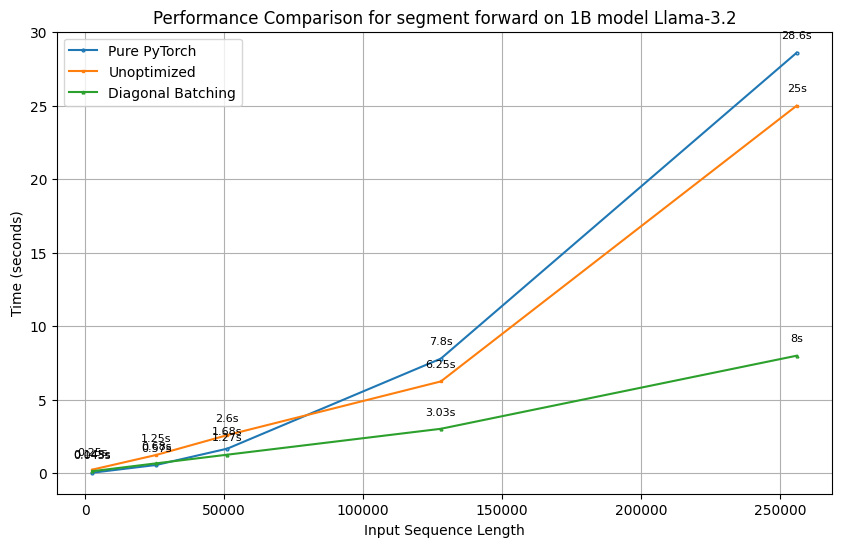

In [97]:
x = [2560,
25600,
51200,
128000,
256000]

y_pure_pytorch = [
    0.043,
    0.57,
    1.68,
    7.8,
    28.6,
]

y_unoptimized = [
    0.25,
    1.25,
    2.6,
    6.25,
    25,
]

y_diagonal_batching = [
    0.145,
    0.68,
    1.27,
    3.03,
    8,
]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(x, y_pure_pytorch, marker='o', label='Pure PyTorch', 
         markerfacecolor='none', markersize=2)
for i, txt in enumerate(y_pure_pytorch):
    plt.annotate(f'{txt}s', (x[i], y_pure_pytorch[i]), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.plot(x, y_unoptimized, marker='s', label='Unoptimized',
         markerfacecolor='none', markersize=2)
for i, txt in enumerate(y_unoptimized):
    plt.annotate(f'{txt}s', (x[i], y_unoptimized[i]),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.plot(x, y_diagonal_batching, marker='^', label='Diagonal Batching',
         markerfacecolor='none', markersize=2) 
for i, txt in enumerate(y_diagonal_batching):
    plt.annotate(f'{txt}s', (x[i], y_diagonal_batching[i]),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.xlabel('Input Sequence Length')
plt.ylabel('Time (seconds)')
plt.title('Performance Comparison for segment forward on 1B model Llama-3.2')
plt.legend()
plt.grid(True)

plt.show()
